Mean Squared Error: 0.12972764225321573


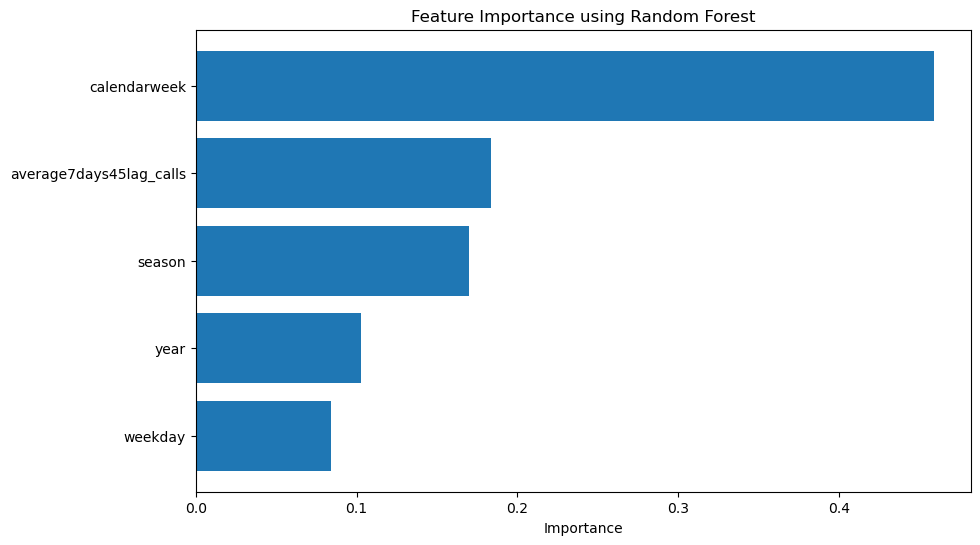

In [50]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

df = pd.read_csv('/Users/frederic/Desktop/Fallstudie-Model-Engineering/data/processed/processed_data.csv')
# Konvertieren der 'date'-Spalte in datetime-Objekte ohne Uhrzeit
df['date'] = pd.to_datetime(df['date']).dt.date
train = pd.read_csv('/Users/frederic/Desktop/Fallstudie-Model-Engineering/data/processed/train_data.csv')
test = pd.read_csv('/Users/frederic/Desktop/Fallstudie-Model-Engineering/data/processed/test_data.csv')
# Feature und Zielvariable
#features = ['weekday', 'schulferien', 'Feiertage' 'calendarweek', 'month', 'quarter', 'season', 'year', 'lag_49_calls', 'lag_365_calls', 'average7days45lag_calls']
features = ['weekday', 'calendarweek', 'season', 'year', 'average7days45lag_calls']

X_train = train[features]
y_train = train['Sick-ratio']
X_test = test[features]
y_test = test['Sick-ratio']

# Modelltraining
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Vorhersagen
y_pred = model.predict(X_test)

# Modellbewertung
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f'Mean Squared Error: {mape}')

# Feature Importance visualisieren
importances = model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10, 6))
plt.title('Feature Importance using Random Forest')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Importance')
plt.show()

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Beste Hyperparameter: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Beste Hyperparameter: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Überprüfe Datum: 2016-01-15
Datum 2016-01-15 nicht in Daten vorhanden.
Tatsächliche vorhandene Daten: [datetime.date(2016, 4, 1) datetime.date(2016, 4, 2)
 datetime.date(2016, 4, 3) ... datetime.date(2019, 5, 25)
 datetime.date(2019, 5, 26) datetime.date(2019, 5, 27)]
Überprüfe Datum: 2016-02-15
Datum 2016-02-15 nicht in Daten vorhanden.
Tatsächliche vorhandene Daten: [datetime.date(2016, 4, 1) datetime.date(2016, 4, 2)
 datetime.date(2016, 4, 3) ... datetime.date(2019, 5, 25)
 datetime.date(2019, 5, 26) datetime.date(2019, 5, 27)]
Überprüfe Datum: 2016-03-15
Datum 2016-03-15 nicht in Daten vorhanden.
Tatsächliche vorhandene Daten: [datetime.date(2016, 4, 1)

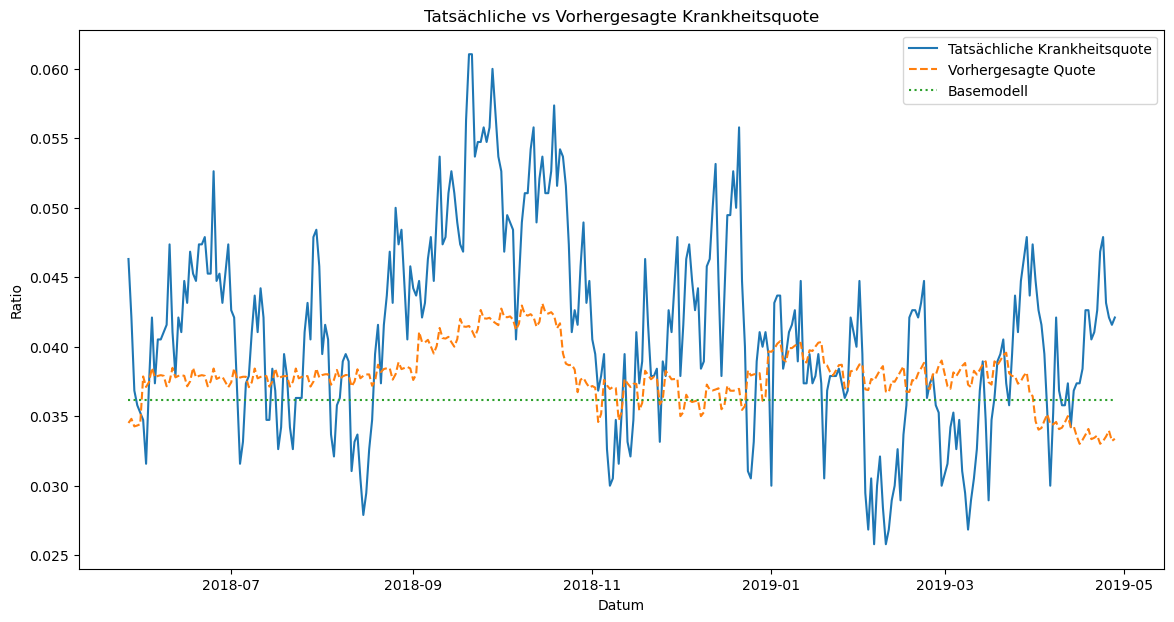

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime, timedelta

# Annahme: Deine Daten liegen bereits in df vor und deine Features sind definiert

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]  # 'auto' entfernt
}

rf = RandomForestRegressor()

try:
    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        cv=5,
        n_jobs=-1,
        verbose=2,
        error_score='raise'
    )
    grid_search.fit(X_train, y_train)
    print("Beste Hyperparameter:", grid_search.best_params_)
except Exception as e:
    print("Fehler während der GridSearchCV:", e)

# Beste Hyperparameter
print("Beste Hyperparameter:", grid_search.best_params_)

# Trainieren des Modells mit den besten Hyperparametern
best_rf = grid_search.best_estimator_

# Deine bestehende Funktion zur Vorhersage am 15. jedes Monats
def predict_for_next_30_days_debug(model, df, date_col='date', feature_cols=features):
    predictions = []
    prediction_dates = []
    
    for year in df['year'].unique():
        for month in range(1, 13):
            prediction_date_str = f'{year}-{month:02d}-15'
            prediction_date = datetime.strptime(prediction_date_str, '%Y-%m-%d').date()
            print(f"Überprüfe Datum: {prediction_date}")  # Debugging-Ausgabe
            
            if prediction_date in df[date_col].values:
                start_date = prediction_date + timedelta(days=15)
                end_date = start_date + timedelta(days=29)  # 29 Tage, um insgesamt 30 Tage zu haben
                print(f"Generiere Vorhersage für Zeitraum: {start_date} bis {end_date}")  # Debugging-Ausgabe
                
                if end_date <= df[date_col].max():
                    future_dates = pd.date_range(start=start_date, end=end_date, freq='D')
                    future_df = pd.DataFrame({
                        'date': future_dates,
                        #'Feiertage': 0,
                        'quarter': pd.to_datetime(future_dates).quarter,
                        'schulferien': 0,
                        'month': pd.to_datetime(future_dates).month,
                        'year': pd.to_datetime(future_dates).year,
                        'season': (pd.to_datetime(future_dates).month % 12 + 3) // 3,
                        'weekday': pd.to_datetime(future_dates).weekday,
                        'calendarweek': pd.to_datetime(future_dates).isocalendar().week,
                        'lag_49_calls': 0,
                        'lag_365_calls': 0,
                        'average7days45lag_calls': 0
                    })
                    
                    future_X = future_df[feature_cols]
                    future_pred = model.predict(future_X)
                    
                    predictions.extend(future_pred)
                    prediction_dates.extend(future_dates)
                else:
                    print(f"Enddatum {end_date} liegt außerhalb des verfügbaren Bereichs.")  # Debugging-Ausgabe
            else:
                print(f"Datum {prediction_date} nicht in Daten vorhanden.")  # Debugging-Ausgabe
                print(f"Tatsächliche vorhandene Daten: {df[date_col].values}")  # Debugging-Ausgabe
    
    return predictions, prediction_dates

# Vorhersagen generieren mit dem getunten Modell
predictions, prediction_dates = predict_for_next_30_days_debug(best_rf, df)

# Überprüfen, ob Vorhersagen generiert wurden
if predictions and prediction_dates:
    # Ergebnisse in einem DataFrame zusammenfassen
    prediction_df = pd.DataFrame({
        'date': prediction_dates,
        'Random Forest': predictions
    })

    # Konvertiere die 'date'-Spalte in beiden DataFrames in datetime64[ns]
    prediction_df['date'] = pd.to_datetime(prediction_df['date'])
    test['date'] = pd.to_datetime(test['date'])

    prediction_df.to_csv('/Users/frederic/Desktop/Fallstudie-Model-Engineering/data/processed/prediction_Sick-ratioRFwLag.csv', index=False)
    
    # Zusammenführen mit tatsächlichen Werten
    merged_df = pd.merge(test, prediction_df, on='date', how='right')

    # Füge die Basemodell-Spalte hinzu und fülle sie mit 9500
    merged_df['Basemodell'] = 0.03617

    # Berechnung des MAPE für das Random Forest Modell
    merged_df.dropna(subset=['Sick-ratio'], inplace=True)  # Entfernen von Zeilen ohne tatsächliche Anrufe
    mape_rf = np.mean(np.abs((merged_df['Sick-ratio'] - merged_df['Random Forest']) / merged_df['Sick-ratio'])) * 100
    print(f'Mean Absolute Percentage Error (MAPE) für das Random Forest Modell: {mape_rf:.2f}%')

    # Berechnung des MAPE für das Basismodell
    mape_base = np.mean(np.abs((merged_df['Sick-ratio'] - merged_df['Basemodell']) / merged_df['Sick-ratio'])) * 100
    print(f'Mean Absolute Percentage Error (MAPE) für das Basismodell: {mape_base:.2f}%')
    # Berechnung des Bias
    bias =  np.mean((merged_df['Random Forest'] - merged_df['calls']))
    print(f'Bias des Modells: {bias:.2f}')

    
    # Plotten der tatsächlichen Werte und Vorhersagen
    plt.figure(figsize=(14, 7))
    plt.plot(merged_df['date'], merged_df['Sick-ratio'], label='Tatsächliche Krankheitsquote')
    plt.plot(merged_df['date'], merged_df['Random Forest'], label='Vorhergesagte Quote', linestyle='--')
    plt.plot(merged_df['date'], merged_df['Basemodell'], label='Basemodell', linestyle=':')
    plt.xlabel('Datum')
    plt.ylabel('Ratio')
    plt.title('Tatsächliche vs Vorhergesagte Krankheitsquote')
    plt.legend()
    plt.show()
else:
    print("Es wurden keine Vorhersagen generiert. Überprüfen Sie die Daten und die Filterbedingungen.")


prediction_df.to_csv('/Users/frederic/Desktop/Fallstudie-Model-Engineering/data/processed/prediction_Sick-ratioRFwLag.csv', index=False)